# Fine-Tuning
使用在`ImageNet`上预训练的`resnet50`在新的数据集上微调

In [1]:
import torch 
from torch import nn 
import torchvision 
from torchvision import transforms as T 
from torch import functional as F 

import os
from d2l import torch as d2l
from PIL import Image 
from matplotlib import pyplot as plt 

查看数据集

In [2]:
data_dir = '../data/fruit_class/'   # 数据文件路径
train_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))   # 读入训练数据
test_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))    # 读入验证数据

image, label = train_data[0] 第0个样本的图片和对应标签   
标签不是独热码格式， 第0张图片的标签 train_data[0][0] = 0    
分别显示训练集和测试集的第一幅图片

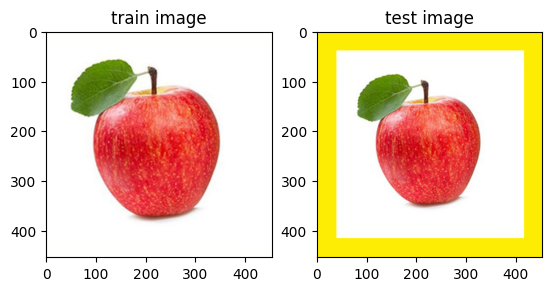

In [3]:
plt.subplot(121)
train_img =  train_data[0][0]
plt.imshow(train_img)
plt.title('train image')

plt.subplot(122)
test_img = test_data[0][0]
plt.imshow(test_img)
plt.title('test image')
plt.show()

预先对图像进行处理，并做`可视化`

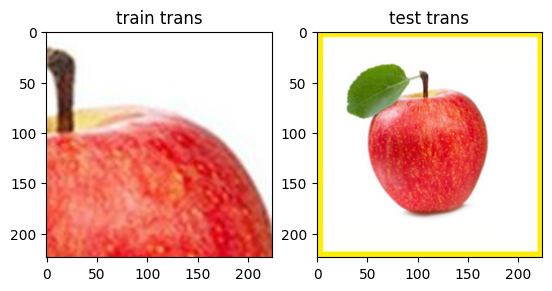

In [4]:
train_trans = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip()
])

test_trans = T.Compose([
    T.Resize(256),
    T.CenterCrop(224)
])

plt.subplot(121)
plt.imshow(train_trans(train_img))
plt.title('train trans')

plt.subplot(122)
plt.imshow(test_trans(test_img))
plt.title('test trans')
plt.show()

设置数据集预处理方法

In [5]:
train_augs = T.Compose([
    train_trans,
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_augs = T.Compose([
    test_trans,
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

读取数据集

In [6]:
train_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs), 
    batch_size = 64, shuffle=True
)
test_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
    batch_size = 64
)

len(train_iter)

11

## 整合数据读取函数

In [7]:
#---------------------数据加载函数---------------------------
# @ batch_size:  读取每个batch的大小
# @ train_trans: 对训练数据进行的增强变换
# @ test_trans:  对测试数据做的预处理变换
# @ return: train_iter, test_iter 迭代对象
#-----------------------------------------------------------
def data_loader(batch_size, train_trans, test_trans):

    train_augs = T.Compose([
        train_trans,
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_augs = T.Compose([
        test_trans,
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs), 
        batch_size=batch_size, shuffle=True
    )
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size = batch_size
    )

    return train_iter, test_iter

读取预训练好的模型

In [8]:
pretrained_net = torchvision.models.resnet50(pretrained=True)
pretrained_net.fc

/home/shilin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shilin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=1000, bias=True)

替换最后的分类层

In [9]:
cls = nn.Sequential(
    nn.Linear(pretrained_net.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 5)
)

pretrained_net.fc = cls
finetune_net = pretrained_net

查看模型的 fc 层

In [10]:
finetune_net.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=5, bias=True)
)

## 整合模型
同时初始化替换的线性层

In [11]:
#---------------------------获取网络----------------------------
# @ num_cls: 数据集需要分类的类别数
# @ return:  返回替换过分类层的resnet50
#--------------------------------------------------------------
def net_get(num_cls=5):
    pretrained_net = torchvision.models.resnet50(pretrained=True)

    cls = nn.Sequential(
        nn.Linear(pretrained_net.fc.in_features, 256),
        nn.ReLU(),
        nn.Linear(256, num_cls)
    )
    if type(cls) == nn.Linear or type(cls) == nn.Conv2d:
        nn.init.xavier_uniform_(cls.weight)

    pretrained_net.fc = cls
    
    return pretrained_net

获取gpu

In [12]:
def try_all_gpus():
    gpu_num = torch.cuda.device_count()
    all_gpus = [torch.device(f'cuda:{i}') for i in range(gpu_num)]
    return all_gpus

try_all_gpus()

[device(type='cuda', index=0)]

## 编写训练函数

In [13]:
#-------------------------------------训练函数----------------------------------------
# @ net: 训练的网络
# @ lr: 学习率
# @ batch_size: 小批量大小
# @ num_epochs: 训练轮数
# @ train_trans: 训练数据增强
# @ test_trans:  测试数据增强
# @ note: 该网络训练函数包含数据读取，只需指定数据变换即可
#-----------------------------------------------------------------------------------
def net_train(net, lr, batch_size, num_epochs, train_trans, test_trans):
    train_iter, test_iter = data_loader(batch_size, train_trans, test_trans)
    device = try_all_gpus()
    print('training on', device)
    net = nn.DataParallel(net, device_ids=device).to(device[0])
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], 
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            features, labels = features.to(device[0]), labels.to(device[0])
            pred = net(features)
            l = loss(pred, labels)
            l.backward()
            optimizer.step()
            timer.stop()

            with torch.no_grad():
                metric.add(l * features.shape[0], d2l.accuracy(pred, labels), features.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i+1) % (num_batches // 5) == 0 or (i+1) == num_batches:
                animator.add(
                    epoch + (i+1) / num_batches,
                    (train_loss, train_acc, None)
                )
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')

列出参数，训练模型

train loss 0.669, train acc 0.976, test acc 0.996
2130.6 examples/sec on [device(type='cuda', index=0)]


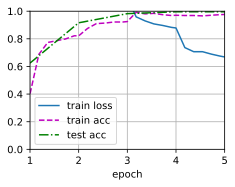

In [14]:
net = net_get()
lr, batch_size, num_epochs = 1e-5, 64, 5
net_train(net, lr, batch_size, num_epochs, train_trans, test_trans)